In [64]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate Bering Strait Heat Flux Figure 07

Generates correlation maps between total transport estimated at mooring A3 and the meridional wind.  No rotation is used in this 

In [65]:
import pandas as pd
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../source')

from constants import MAP_PROJ, MAP_EXTENT
from constants import MOORING_DIRPATH, REANALYSIS_DIRPATH
import utilities as utils

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl

## Read Bearing Strait heat flux and convert to DataArray

In [51]:
heat = utils.read_mooring('TRANSPORT', 'MeanCorr')
heat = heat.dropna()  # Drop NaNs
heat = xr.DataArray.from_series(heat)
heat = heat.rename({'date': 'time'})
heat

<xarray.DataArray 'MeanCorr' (time: 263)>
array([0.6 , 0.62, 1.09, ..., 1.44, 1.45, 1.58])
Coordinates:
  * time     (time) datetime64[ns] 1990-09-01 1990-10-01 ... 2017-06-01

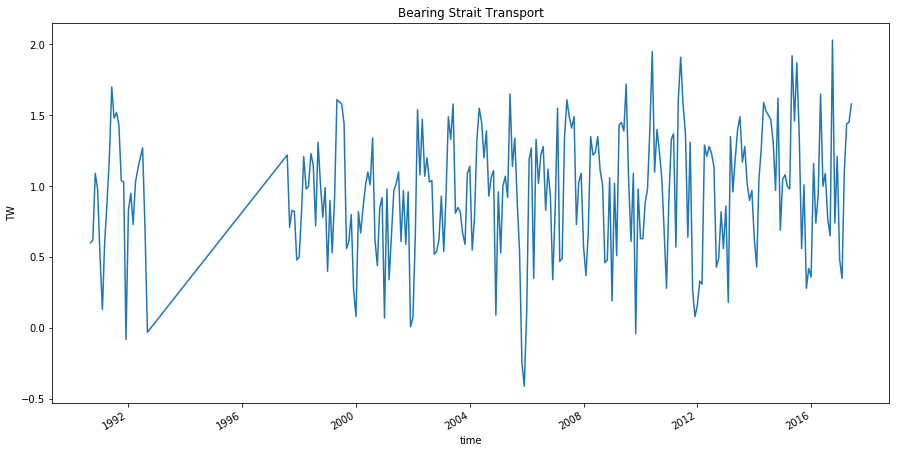

In [53]:
fig, ax = plt.subplots(figsize=(15,7))
heat.plot(ax=ax)
ax.set_title('Bearing Strait Transport')
ax.set_ylabel('TW');

## Get zonal winds

In [54]:
v10m = xr.open_dataset(os.path.join(REANALYSIS_DIRPATH, 'V10M', 'MERRA2_400.instM_2d_asm_Nx.V10M.month.1980to2018.nc4'))
v10m = v10m['V10M'].loc[dict(time=slice('1990-01-01','2017-12-01'), lat=slice(20,90))]
v10m = v10m.sel(time=heat.time)  # Select same dates for Heat transport
v10m

<xarray.DataArray 'V10M' (time: 263, lat: 141, lon: 576)>
[21359808 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 88.0 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1990-09-01 1990-10-01 ... 2017-06-01
Attributes:
    long_name:     10-meter_northward_wind
    units:         m s-1
    vmax:          999999987000000.0
    vmin:          -999999987000000.0
    valid_range:   [-9.99999987e+14  9.99999987e+14]
    origname:      V10M
    fullnamepath:  /V10M

## Calculate correlation coeficient
I haven't figured out how to do this in one fell swoop, so I do it in several steps.
1. Calculate anomaly time series in time dimensions for UV10M and heat flux
2. Calculate gridcell covariances between the two data sets
3. Calculate standard deviations for the two data sets
4. Calculate correlation coeficients for each grid cell

## Check heat flux and winds are same size

In [55]:
print (heat.shape)
print (v10m.shape)

(263,)
(263, 141, 576)


### Step 1.  Calculate anomaly time series

In [56]:
def anomaly(x, dim=None):
    return x - x.mean(dim=dim)

In [57]:
heatAnom = heat.groupby('time.month').apply(anomaly)
v10mAnom = v10m.groupby('time.month').apply(anomaly, dim='time')

### Step 2. Calculate covariance

In [58]:
cov = (v10mAnom * heatAnom).groupby('time.month').mean(dim='time')

### Step 3. Calculate standard deviations

In [59]:
heatStd = heat.groupby('time.month').std(dim='time')
v10mStd = v10m.groupby('time.month').std(dim='time')

### Step 4. Calculate correlation coeficient

In [60]:
corrcoef = cov / (heatStd * v10mStd)

In [61]:
from scipy import stats

# calculate t-statistic
n = heat.groupby('time.month').count()
dgf = np.sqrt(n - 2)
den = np.sqrt(1 - (corrcoef*corrcoef))
t = corrcoef*dgf / den

p = 1 - stats.t.cdf(np.abs(t), 21)
r = corrcoef.where(2*p < 0.05)

## Plot results

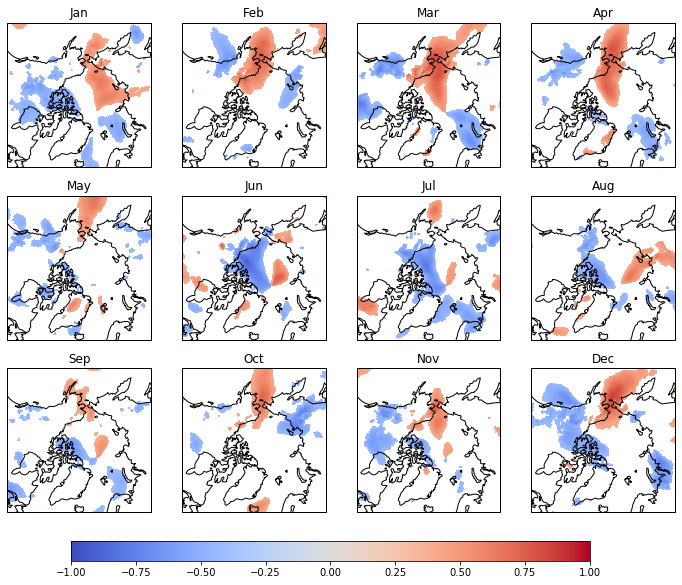

In [63]:
fig = plt.figure(figsize=(12, 9))

land = cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='k', facecolor=0.5)

cmap = plt.get_cmap('coolwarm')
norm = mpl.colors.Normalize(vmin=-1., vmax=1.)

ax = []
monthstr = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, mstr in enumerate(monthstr):
        
    ax.append( plt.subplot(3, 4, i+1, projection=MAP_PROJ) )
    
    ax[i].set_extent(MAP_EXTENT, MAP_PROJ)
    cax = r.isel(month=i).plot(ax=ax[i], transform=ccrs.PlateCarree(), add_colorbar=False, 
                               norm=norm, cmap=cmap)
    ax[i].coastlines()
    #ax[i].add_feature(land, zorder=1)
    ax[i].set_title(mstr)

axc = fig.add_axes([0.2, 0.05, 0.6, 0.03])
cbar = mpl.colorbar.ColorbarBase(axc, orientation='horizontal', norm=norm, cmap=cmap)

fig.savefig(os.path.join('MERRA2_V10M_BSTransport_Correlation_Month.png'))
#ax.add_feature(cfeature.LAND, zorder=1, facecolor=0.3)